In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset_orig = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset, valset = random_split(trainset_orig, (0.8, 0.2))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
conv_block_maker = lambda in_c, out_c, k_s, s, p: nn.Sequential(
    nn.Conv2d(in_c, out_c, k_s, s, p),
    nn.BatchNorm2d(out_c),
    nn.ReLU(),
)

inception_block_maker = lambda in_c, filt_1, filt_3, filt_5, filt_3_r, filt_5_r, p: [
    conv_block_maker(in_c, filt_1, 1, 1, 0), #block 1

    nn.Sequential(conv_block_maker(in_c, filt_3_r, 1, 1, 0), #block 2
    conv_block_maker(filt_3_r, filt_3, 3, 1, 1)), #block 2
    
    nn.Sequential(conv_block_maker(in_c, filt_5_r, 1, 1, 0), #block 3
    conv_block_maker(filt_5_r, filt_5, 5, 1, 2)), #block 3

    nn.Sequential(nn.MaxPool2d((3,3), (1,1), (1,1)),
    conv_block_maker(in_c, p, 1, 1, 0)), #block 4
]

class inception_block(nn.Module):
    def __init__(self, in_c, filt_1, filt_3, filt_5, filt_3_r, filt_5_r, p):
        super(inception_block, self).__init__()
        self.block_1 = conv_block_maker(in_c, filt_1, 1, 1, 0)
        self.block_2 = nn.Sequential(conv_block_maker(in_c, filt_3_r, 1, 1, 0), #block 2
    conv_block_maker(filt_3_r, filt_3, 3, 1, 1))
        self.block_3 = nn.Sequential(conv_block_maker(in_c, filt_5_r, 1, 1, 0), #block 3
    conv_block_maker(filt_5_r, filt_5, 5, 1, 2))
        self.block_4 = nn.Sequential(nn.MaxPool2d((3,3), (1,1), (1,1)),
    conv_block_maker(in_c, p, 1, 1, 0))
    def forward(self, t):
        First_Block_Out = self.block_1(t)
        Second_Block_Out = self.block_2(t)
        Third_Block_Out = self.block_3(t)
        Fourth_Block_Out = self.block_4(t)
        return torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1)

aux_class = lambda in_c,num_c: nn.Sequential(
    nn.AdaptiveAvgPool2d((4,4)),
    nn.Conv2d(in_c, 128, 1, 1, 0),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(2048,1024),
    nn.Dropout(0.7),
    nn.Linear(1024, num_c),
)

class inception_model(nn.Module):
    def __init__(self, out_c):
        super(inception_model, self).__init__()
        self.block_1 = nn.Sequential(
            conv_block_maker(3,64,7,2,3),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            conv_block_maker(64,64,1,1,0),
            conv_block_maker(64,192,3,1,1),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(192,64,128,32,96,16,32),
            inception_block(256,128,192,96,128,32,64),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(480,192,208,48,96,16,64),)
        self.block_2 = nn.Sequential(
            inception_block(512,160,224,64,112,24,64),
            inception_block(512,128,256,64,128,24,64),
            inception_block(512,112,288,64,144,32,64),)
        self.block_3 = nn.Sequential(
            inception_block(528,256,320,128,160,32,128),
            nn.MaxPool2d((3,3),stride=2,padding=0,ceil_mode =True),
            inception_block(832,256,320,128,160,32,128),
            inception_block(832,384,384,128,192,48,128),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten(1),
            nn.Dropout(p=0.4),
            nn.Linear(in_features =1024,out_features = out_c))
        self.aux_1 = aux_class(512,out_c)
        self.aux_2 = aux_class(528,out_c)
    def forward(self, t):
        t = self.block_1(t)
        aux_1_out = self.aux_1(t)
        t = self.block_2(t)
        aux_2_out = self.aux_2(t)
        t = self.block_3(t)
        return t, aux_1_out, aux_2_out

In [4]:
Device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
def Train_Validate_Model(Model, Train_Loader, Val_Loader, Num_Of_Train_Samples, Num_Of_Val_Samples, Criterion,Optimizer, Num_Epochs):
    # ==========================Training Part ================================#
    Train_Loss_History, Train_Accuracy_History, Val_Loss_History, Val_Accuracy_History = []
    for epoch in (pbar:=tqdm(range(Num_Epochs))):
        Num_Of_Predicted_Correctly, Train_Cummulative_Loss = 0
        for batch_samples,targets in Train_Loader:
            batch_samples = batch_samples.to(device=Device)
            targets = targets.to(device=Device)

            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)
            Main_Loss =  Criterion(Network_Predictions, targets) + (0.3 * Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

            Optimizer.zero_grad() 
            Main_Loss.backward() 
            Optimizer.step()
            
            _, Train_Samples_Predictions = Network_Predictions.max(1)
            Train_Samples_Predictions = Train_Samples_Predictions.to(device=Device)
            Num_Of_Predicted_Correctly += (Train_Samples_Predictions == targets).float().sum().item()
            Train_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
        Train_Cummulative_Loss /= Num_Of_Train_Samples
        Train_Loss_History.append(Train_Cummulative_Loss)
        Train_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Train_Samples
        Train_Accuracy_History.append(Train_Accuracy)
    # =============================== End of Training Part ========================#
    
    #============================ Validation Part ===================================#
    
        Num_Of_Predicted_Correctly = 0
        with torch.no_grad(): # we're in test mode so we don't need to calc the gradients
            Val_Cummulative_Loss = 0
            for batch_samples,targets in Val_Loader:
                batch_samples = batch_samples.to(device=Device)
                targets = targets.to(device=Device)

                Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)

                Main_Loss = Criterion(Network_Predictions, targets) + (0.3 *  Criterion(Aux_1_Predictions, targets)) + (0.3 * Criterion(Aux_2_Predictions, targets))

                _, Val_Samples_Predictions = Network_Predictions.max(1)
                Val_Samples_Predictions = Val_Samples_Predictions.to(device=Device)
                Num_Of_Predicted_Correctly += (Val_Samples_Predictions == targets).float().sum().item()
                Val_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
            Val_Cummulative_Loss /= Num_Of_Val_Samples
            Val_Loss_History.append(Val_Cummulative_Loss)
            Val_Accuracy = Num_Of_Predicted_Correctly / Num_Of_Val_Samples
            Val_Accuracy_History.append(Val_Accuracy)
            # =============================== End of Validation Part ========================#

            pbar.set_description(f"train-loss:{Train_Cummulative_Loss},train=acc:{Train_Accuracy},val-loss:{Val_Cummulative_Loss},val-loss:{Val_Accuracy}")
            if epoch % 10 == 0:
                print()
    torch.save(Model.state_dict(), "InceptionNet_Model")
    return Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History

In [6]:
def Plot_Model_History(Train_Accuracy_History , Val_Accuracy_History, Train_Loss_History, Val_Loss_History):
    # plot Accuracy
    plt.plot(Train_Accuracy_History, marker='o')
    plt.plot(Val_Accuracy_History, marker='o')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plot Loss
    plt.plot(Train_Loss_History, marker='8')
    plt.plot(Val_Loss_History, marker='8')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

train-loss:2.454709456062317,train=acc:0.4383,val-loss:1.9743970821380614,val-loss:0.5578:   1%|          | 1/100 [00:14<23:24, 14.19s/it]

train-loss:0.4297590564250946,train=acc:0.91115,val-loss:1.4638091262817383,val-loss:0.755:  11%|█         | 11/100 [02:24<19:21, 13.05s/it] 

train-loss:0.14953833563923835,train=acc:0.9695,val-loss:1.8886448585510254,val-loss:0.7594:  21%|██        | 21/100 [04:34<17:04, 12.97s/it]  

train-loss:0.10786335176378488,train=acc:0.978325,val-loss:1.9601278884887696,val-loss:0.7743:  31%|███       | 31/100 [06:44<15:02, 13.08s/it]

train-loss:0.08985759142786265,train=acc:0.9823,val-loss:2.014686489868164,val-loss:0.776:  41%|████      | 41/100 [08:56<13:01, 13.25s/it]    

train-loss:0.0645330767042935,train=acc:0.9877,val-loss:2.2296210757255555,val-loss:0.7701:  51%|█████     | 51/100 [11:08<10:41, 13.09s/it]  

train-loss:0.05555147557035089,train=acc:0.988675,val-loss:2.228994188308716,val-loss:0.7742:  61%|██████    | 61/100 [13:19<08:31, 13.10s/it]  

train-loss:0.04460245286151767,train=acc:0.9919,val-loss:2.4134059242248536,val-loss:0.7774:  71%|███████   | 71/100 [15:30<06:15, 12.96s/it]  

train-loss:0.0425790480485186,train=acc:0.99245,val-loss:2.330969125366211,val-loss:0.7722:  81%|████████  | 81/100 [17:39<04:03, 12.79s/it]    

train-loss:0.03530110296625644,train=acc:0.993375,val-loss:2.389294002532959,val-loss:0.7742:  91%|█████████ | 91/100 [19:50<01:57, 13.07s/it] 

train-loss:0.032098029458522796,train=acc:0.9945,val-loss:2.4975517730712893,val-loss:0.7776: 100%|██████████| 100/100 [21:48<00:00, 13.08s/it] 


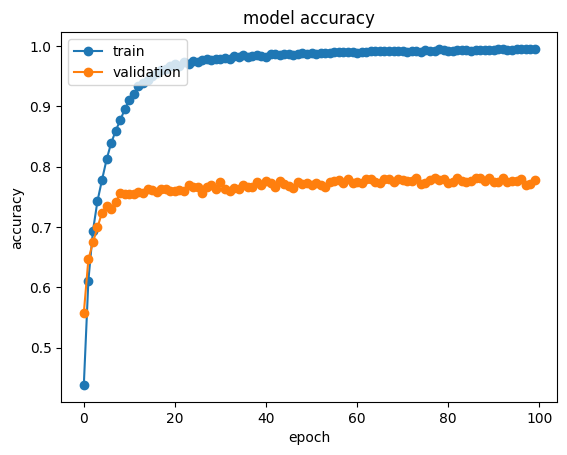

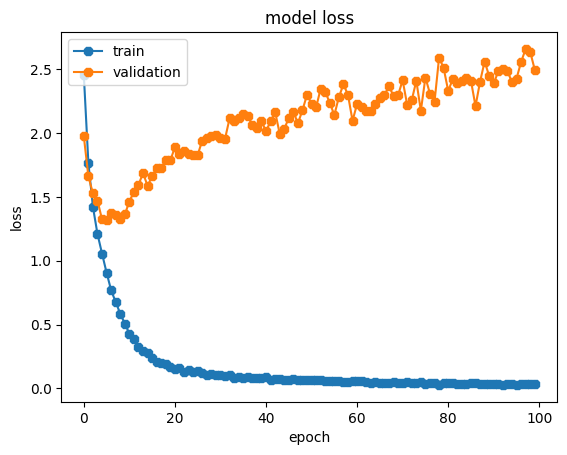

In [7]:
def Propagate_Network():
    Inception_Model = inception_model(out_c=10).to(device=Device)
    Cross_Entropy_Criterion = nn.CrossEntropyLoss()
    Adam_Optimizer = optim.Adam(Inception_Model.parameters(), lr=0.001)
    Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History = Train_Validate_Model(Model = Inception_Model, Train_Loader = trainloader,Val_Loader = valloader,Num_Of_Train_Samples = len(trainset),
                         Num_Of_Val_Samples = len(valset),Criterion = Cross_Entropy_Criterion,Optimizer = Adam_Optimizer,Num_Epochs = 100)
    Plot_Model_History( Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History)
Propagate_Network()

In [11]:
def Model_Test(Test_Loader, Num_Of_Test_Samples):
    Test_CIFAR = inception_model(out_c=10).to(device=Device)
    Test_CIFAR.load_state_dict(torch.load('./InceptionNet_Model'))
    Test_CIFAR.eval().cuda()
    Num_Of_Correct_Predicted = 0
    with torch.no_grad():
        for batch_samples,targets in tqdm(Test_Loader):
            batch_samples, targets = batch_samples.to(Device), targets.to(Device)
            
            # Model Predictions
            Predictions, _, _ = Test_CIFAR(batch_samples)
            
            _, Predicted_Class = Predictions.max(1)
            
            # Calc number of samples that predicted correctly
            Num_Of_Correct_Predicted += (Predicted_Class == targets).float().sum().item()
    Test_Accuracy = Num_Of_Correct_Predicted / Num_Of_Test_Samples
    print("Test Accuracy = ", Test_Accuracy*100 , "%")
Model_Test(Test_Loader= testloader, Num_Of_Test_Samples=10000)

100%|██████████| 79/79 [00:01<00:00, 72.02it/s]

Test Accuracy =  77.72 %
